<a href="https://colab.research.google.com/github/skbagass/Pengembangan-Sistem-Keamanan-Rumah-Pintar-menggunakan-Metode-Pengenalan-Wajah-Melalui-CNN/blob/main/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install MTCNN

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.7 MB/s eta 0:00:00


In [ ]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


# Load Dataset

In [ ]:
!unzip dataset\ facenet\ 2.1.zip

# Import Library

In [ ]:
import numpy as np
import pandas as pd
import cv2
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

import os
print(os.listdir("/content/dataset facenet 2.1/"))


['train', 'test']


#Mencetak bentuk gambar (tinggi, lebar, dan jumlah saluran warna).





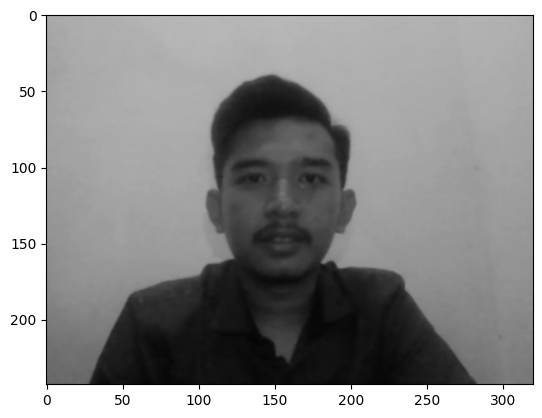

(243, 320, 3)


In [ ]:
img = cv2.imread('/content/dataset facenet 2.1/train/ikhsanudin/Subject12.ikhsan.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()
print(img.shape)

# Esktrak wajah dari gambar yang diinput

1/1 [==============================] - 0s 159ms/step


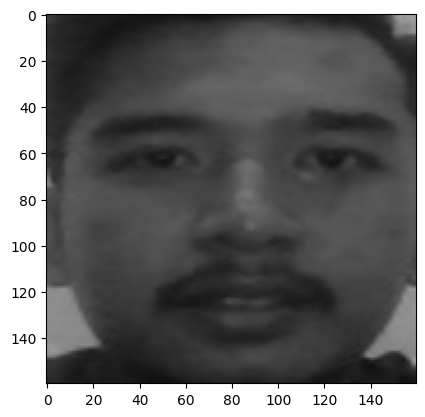

(160, 160, 3)


In [ ]:
def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

pixels = extract_face('/content/dataset facenet 2.1/train/ikhsanudin/Subject12.ikhsan.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

# Melakukan augmentasi pada gambar

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Membuat objek ImageDataGenerator untuk augmentasi gambar
datagen = ImageDataGenerator(
    rotation_range=20,  # Rentang rotasi gambar
    width_shift_range=0.2,  # Rentang pergeseran horizontal
    height_shift_range=0.2,  # Rentang pergeseran vertikal
    shear_range=0.2,  # Rentang pergeseran shear
    zoom_range=0.2,  # Rentang zoom gambar
    horizontal_flip=True,  # Flip gambar secara horizontal
    fill_mode='nearest'  # Pengisian piksel yang hilang
)

In [ ]:
def augment_images(images):
    augmented_images = []
    for image in images:
        # Reshape gambar menjadi bentuk (1, height, width, channels)
        image = np.expand_dims(image, axis=0)
        # Generate gambar yang telah di-augmentasi menggunakan ImageDataGenerator
        augmented = datagen.flow(image, batch_size=1)[0][0]
        augmented_images.append(augmented)
    return np.asarray(augmented_images)

#Memuat wajah dan menimpan dalam file(.npz)

In [ ]:
def load_face(dir):
    faces = list()
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) )
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('/content/dataset facenet 2.1/train/')
print(trainX.shape, trainy.shape)
trainX_augmented = augment_images(trainX)
trainy_augmented = np.repeat(trainy, len(trainX_augmented) // len(trainX))
# load test dataset
testX, testy = load_dataset('/content/dataset facenet 2.1/test/')
print(testX.shape, testy.shape)

# save and compress the dataset
np.savez_compressed('FaceNet dataset_augmented.npz', trainX_augmented, trainy_augmented, testX, testy)

1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 235ms/step
loaded 52 sample for class: sendy
1/1 [==============================] - 0s 182ms/step
loaded 54 sample for class: bagas
1/1 [==============================] - 0s 163ms/step
loaded 56 sample for class: didit
1/1 [==============================] - 0s 154ms/step
loaded 54 sample for class: ikhsanudin
1/1 [==============================] - 0s 174ms/step
loaded 56 sample for class: rifqi
(272, 160, 160, 3) (272,)
1/1 [==============================] - 0s 159ms/step
loaded 14 sample for class: sendy
1/1 [==============================] - 0s 167ms/step
loaded 14 sample for class: bagas
1/1 [==============================] - 0s 205ms/step
loaded 12 sample for class: didit
1/1 [==============================] - 0s 178ms/step
loaded 14 sample for class: ikhsanudin
1/1 [==============================] - 0s 168ms/step
loaded 12 sample for class: rifqi
(66, 160, 160, 3) (66,)


In [ ]:
data = np.load('FaceNet dataset_augmented.npz')
trainX_augmented, trainy_augmented, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX_augmented.shape, trainy_augmented.shape, testX.shape, testy.shape)

Loaded:  (272, 160, 160, 3) (272,) (66, 160, 160, 3) (66,)


#Load FaceNet Model

In [ ]:
!pip install keras-facenet
from keras_facenet import FaceNet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10370 sha256=c81d9623247b531bd04b1237daab77c2c45ab5fcc7f7f53fba7fba9d2d2fbfab
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [ ]:
# load the facenet model
model = FaceNet()
print('Loaded Model')

Loaded Model


#Mendapatkan wembedding dari setiap gambar



In [ ]:
def get_embedding(model, face):
    face = face.astype('float32')
    detection = model.extract(face, threshold=0.95)
    sample = np.expand_dims(face, axis=0)
    yhat = model.embeddings(sample)
    return yhat[0]

#konversi setiap wajah di data latih ke embedding

In [ ]:
emdTrainX = list()
for face in trainX:
    emd = get_embedding(model, face)
    emdTrainX.append(emd)

1/1 [==============================] - 0s 169ms/step


In [ ]:
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

(272, 512)


#konversi setiap wajah di data uji ke embedding

In [ ]:
emdTestX = list()
for face in testX:
    emd = get_embedding(model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)
np.savez_compressed('FaceNet dataset embeddings.npz', emdTrainX, trainy, emdTestX, testy)

1/1 [==============================] - 0s 103ms/step
(66, 512)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=272, test=66
Accuracy: train=99.265, test=93.939


In [ ]:
from sklearn.metrics import classification_report

train_report = classification_report(trainy_enc, yhat_train, target_names=out_encoder.classes_)
test_report = classification_report(testy_enc, yhat_test, target_names=out_encoder.classes_)


print('Training Classification Report:')
print(train_report)
print('')

print('Testing Classification Report:')
print(test_report)

Training Classification Report:
              precision    recall  f1-score   support

       bagas       1.00      1.00      1.00        54
       didit       0.98      0.98      0.98        56
  ikhsanudin       1.00      1.00      1.00        54
       rifqi       0.98      0.98      0.98        56
       sendy       1.00      1.00      1.00        52

    accuracy                           0.99       272
   macro avg       0.99      0.99      0.99       272
weighted avg       0.99      0.99      0.99       272


Testing Classification Report:
              precision    recall  f1-score   support

       bagas       1.00      0.86      0.92        14
       didit       0.86      1.00      0.92        12
  ikhsanudin       1.00      0.86      0.92        14
       rifqi       0.86      1.00      0.92        12
       sendy       1.00      1.00      1.00        14

    accuracy                           0.94        66
   macro avg       0.94      0.94      0.94        66
weighted avg 

In [ ]:
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
train_cm = confusion_matrix(trainy_enc, yhat_train)
test_cm = confusion_matrix(testy_enc, yhat_test)

# print confusion matrix
print('Training Confusion Matrix:')
print(train_cm)
print('')

print('Testing Confusion Matrix:')
print(test_cm)

Training Confusion Matrix:
[[54  0  0  0  0]
 [ 0 55  0  1  0]
 [ 0  0 54  0  0]
 [ 0  1  0 55  0]
 [ 0  0  0  0 52]]

Testing Confusion Matrix:
[[12  1  0  1  0]
 [ 0 12  0  0  0]
 [ 0  1 12  1  0]
 [ 0  0  0 12  0]
 [ 0  0  0  0 14]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model = FaceNet()

#uji predict pada gambar ramdom

Predicted: 
['bagas' 'didit' 'ikhsanudin' 'rifqi' 'sendy'] 
[ 3.98240851 84.71028012  2.96364027  4.59641234  3.74725877]
Expected: didit


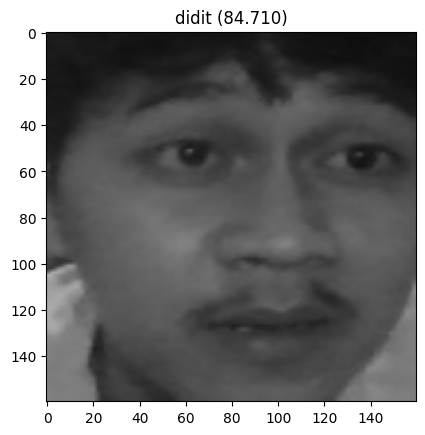

In [ ]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

#Ekspor file menjadi model.h5

In [ ]:
from google.colab import files

files.download('Face_recognition.h5')